In [54]:
#tabular data imports :
import pandas as pd
import numpy as np
import env
from env import user, password, host
from pydataset import data

# visualization imports:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
# success metrics from earlier in the week: mean squared error and r^2 explained variance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

from scipy.stats import pearsonr, spearmanr
from scipy.stats import shapiro

import warnings
warnings.filterwarnings("ignore")
import wrangle as w
import explore as e
import os
directory = os.getcwd()

### 1. Select a dataset with a continuous target variable.

In [2]:
swiss = data('swiss')
swiss.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


### 2. Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

In [5]:
swiss.shape

(47, 6)

In [3]:
swiss.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, Courtelary to Rive Gauche
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fertility         47 non-null     float64
 1   Agriculture       47 non-null     float64
 2   Examination       47 non-null     int64  
 3   Education         47 non-null     int64  
 4   Catholic          47 non-null     float64
 5   Infant.Mortality  47 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 2.6+ KB


In [6]:
train, validate, test = w.split_data(swiss)


    train -> (28, 6)
    validate -> (9, 6)
    test -> (10, 6)


### 3. Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

In [7]:
# 1. create the object
scaler = sklearn.preprocessing.MinMaxScaler()

# 2. fit the object (learn the min and max value)
scaler.fit(train.drop(columns=['Fertility']))

MinMaxScaler()

In [9]:
X = train.drop(columns=['Fertility'])
y = train['Fertility']

In [12]:
baseline = y.mean()
round(baseline,2)

69.64

In [13]:
def evaluate_reg(y, yhat):
    '''
    based on two series, y_act, y_pred, (y, yhat), we
    evaluate and return the root mean squared error
    as well as the explained variance for the data.
    
    returns: rmse (float), rmse (float)
    '''
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

In [14]:
baseline_array = np.repeat(baseline, y.shape[0])

In [17]:
baseline_rmse, baseline_r2 = evaluate_reg(y, baseline_array)

In [18]:
eval_df = pd.DataFrame([{
    'model': 'baseline',
    'rmse': baseline_rmse,
    'r2': baseline_r2
}])

In [19]:
eval_df

,model,rmse,r2
0,baseline,12.141353,0.0


### Ordinary Least Squares (OLS)

#### OLS is our standard linear regression algorithm and is computed by minimizing the sum of squared differences in the linear model (residual) with the actual data points

## simple linear regression + RFE
### send in only one feature

In [22]:
# initial ML model
lr1 = LinearRegression()

# rfe has entered the chat:
rfe = RFE(lr1, n_features_to_select=1)

# fit
rfe.fit(X, y)

# transform
X_train_rfe = rfe.transform(X)

X_val_rfe = rfe.transform(validate.drop(columns=['Fertility']))

In [23]:
# feature that it selected?
rfe.get_feature_names_out()

array(['Infant.Mortality'], dtype=object)

In [24]:
# lets make a X and y for val and test:
X_val, y_val = validate.drop(
    columns=['Fertility']
), validate['Fertility']
X_test, y_test = test.drop(
    columns=['Fertility']
), test['Fertility']

In [25]:
lr1

LinearRegression()

In [26]:
# lr1 as an object was created for our RFE process,
# lets just use that same object for our first model
lr1.fit(X_train_rfe, y)

LinearRegression()

In [27]:
y_pred_val = lr1.predict(X_val_rfe)

In [28]:
# we filled in our first row of data
# for our evaluation df with training score
# lets ensure we compare apples to apples
# and continue to use training scores (at least this df*)
# * we still will want to retain these validation scores
# for comparison against our "best" models to check for overfitting
evaluate_reg(y, lr1.predict(X_train_rfe))

(11.189614628113986, 0.15063160274179743)

In [29]:
eval_df.columns

Index(['model', 'rmse', 'r2'], dtype='object')

In [30]:
# pd.concat is a one-liner so I dont really feel the need to
# create a whole new function for this atm even though
# we will do it a few times:
rmse, r_2 = evaluate_reg(y, lr1.predict(X_train_rfe))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'model': 'ols_rfe_1',
        'rmse': rmse,
        'r2': r_2
    }
])], ignore_index=True, axis=0)

In [31]:
eval_df

,model,rmse,r2
0,baseline,12.141353,0.000000
1,ols_rfe_1,11.189615,0.150632


### examine the model
## $y=𝛽_0 + 𝛽_i x_i$
**intercept** ($𝛽_0$): Value we predict if x is 0. Depending on our x variables, this may not be valuable

**coefficients** ($𝛽_i$): Define how our prediction changes as x changes. A one-unit increase in x causes our model to predict a coef unit change in y, holding all other independent variables constant
### Intrepretation
For every 1 [unit] increase in [feature], we predict a [# unit] increase in [target_variable]

In [32]:
# (𝛽_i , 𝛽_0)
(lr1.coef_, lr1.intercept_)

(array([1.97889992]), 30.220343809892256)

In [33]:
val_rmse, val_r2 = evaluate_reg(y_val, lr1.predict(X_val_rfe))
val_dict = {
    'model': 'ols_rfe_1',
    'val_rmse': val_rmse,
    'val_r2': val_r2
}

In [34]:
val_scores = [val_dict]

## Multiple Regression

$y = 𝛽_0 + 𝛽_1 x_1 + 𝛽_2 x_2 + 𝛽_3 x_3$

### Model using OLS

In [35]:
# same process here, we are just changing the number of
# features that we are using in selecting our outcome in OLS
lr2 = LinearRegression()

# fit it:
lr2.fit(X, y)

# use it:

LinearRegression()

### Evaluate

In [36]:
# pd.concat is a one-liner so I dont really feel the need to
# create a whole new function for this atm even though
# we will do it a few times:
rmse, r_2 = evaluate_reg(y, lr2.predict(X))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'model': 'ols_all_feats',
        'rmse': rmse,
        'r2': r_2
    }
])], ignore_index=True, axis=0)

In [37]:
val_rmse, val_r2 = evaluate_reg(y_val, lr2.predict(X_val))
val_dict = {
    'model': 'ols_all_feats',
    'val_rmse': val_rmse,
    'val_r2': val_r2
}
val_scores.append(val_dict)

In [38]:
eval_df

,model,rmse,r2
0,baseline,12.141353,0.000000
1,ols_rfe_1,11.189615,0.150632
2,ols_all_feats,6.157281,0.742816


### LassoLars
#### LASSO = Least Absolute Shrinkage and Selection Operator
#### LARS = Least Angle Regression
- Performs intrinsic feature selection and noise reduction to avoid overfitting
- The most important hyperparameter is alpha
    - alpha determines the degree of regularization applied to the model
    - The lowest alpha is zero, and this represents no regularization (identical to OLS)
    - There is no limit to alpha, but as it rises, it will reach a point where performance no longer changes (often because you've regularized all of your coefficients to zero
    - Generally speaking, the higher the alpha, the lower your risk for overfitting
#### alpha = 1.0 is a good place to start
#### alpha = 0, identical to OLS
#### alpha = 1

In [40]:
# fit a version of this that has an alpha of 1:
# make it
lasso = LassoLars(alpha=1)
# fit it:
lasso = lasso.fit(X, y)

In [42]:
(lasso.coef_, lr2.coef_)

(array([-0.19901009, -0.26656774, -1.02146353,  0.09927321,  2.08921618]),
 array([-0.20243731, -0.30641886, -1.03283915,  0.0959672 ,  2.28042747]))

### Evaluate

In [43]:
# pd.concat is a one-liner so I dont really feel the need to
# create a whole new function for this atm even though
# we will do it a few times:
rmse, r_2 = evaluate_reg(y, lasso.predict(X))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'model': 'lasso',
        'rmse': rmse,
        'r2': r_2
    }
])], ignore_index=True, axis=0)

In [44]:
val_rmse, val_r2 = evaluate_reg(y_val, lasso.predict(X_val))
val_dict = {
    'model': 'lasso',
    'val_rmse': val_rmse,
    'val_r2': val_r2
}

In [45]:
val_scores.append(val_dict)

In [46]:
eval_df

,model,rmse,r2
0,baseline,12.141353,0.000000
1,ols_rfe_1,11.189615,0.150632
2,ols_all_feats,6.157281,0.742816
3,lasso,6.176946,0.741171


## Polynomial Regression

$y = β_0 + β_i x + β_k x^k$

### process

#### 1. create new features based on degrees
#### 2. fit on a linear regression model

In [48]:
# do a preprocessing step with our training data
# to transorm our x into combinations of x and x^2, x^3, etc
pf = PolynomialFeatures(degree=2)
# fit the thing, also use it
x_train_sq = pf.fit_transform(X)
# use this transformer to change our val and test:
x_val_sq = pf.transform(X_val)
x_test_sq = pf.transform(X_test)

In [49]:
# make a new model for our polynomial regressor:
plyreg = LinearRegression()
plyreg.fit(x_train_sq, y)

LinearRegression()

Evaluate

In [50]:
# pd.concat is a one-liner so I dont really feel the need to
# create a whole new function for this atm even though
# we will do it a few times:
rmse, r_2 = evaluate_reg(y, plyreg.predict(x_train_sq))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'model': 'quad_reg',
        'rmse': rmse,
        'r2': r_2
    }
])], ignore_index=True, axis=0)

In [51]:
val_rmse, val_r2 = evaluate_reg(y_val, plyreg.predict(x_val_sq))
val_dict = {
    'model': 'quad_reg',
    'val_rmse': val_rmse,
    'val_r2': val_r2
}

In [52]:
val_scores.append(val_dict)

In [53]:
eval_df

,model,rmse,r2
0,baseline,12.141353,0.000000
1,ols_rfe_1,11.189615,0.150632
2,ols_all_feats,6.157281,0.742816
3,lasso,6.176946,0.741171
4,quad_reg,3.550531,0.914483


## Generalized Linear Model (GLM)
The most flexible regression algorithm, the GLM allows for different distributions, beyond just the Normal Distribution for OLS (and other models based on OLS, like LASSO). We will use the TweedieRegressor method to create a GLM using sklearn.

About power:

    power = 0: Normal Distribution
    power = 1: Poisson Distribution
    power = (1,2): Compound Distribution
    power = 2: Gamma Distribution
    power = 3: Inverse Gaussian Distribution

In [55]:
# same process as before!
# make the dang thing!
gams = TweedieRegressor(power=2)
# fit the dang ol thing
gams.fit(X, y)
# use it!

TweedieRegressor(power=2)

Evaluate

In [56]:
# pd.concat is a one-liner so I dont really feel the need to
# create a whole new function for this atm even though
# we will do it a few times:
rmse, r_2 = evaluate_reg(y, gams.predict(X))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'model': 'gamma_ols',
        'rmse': rmse,
        'r2': r_2
    }
])], ignore_index=True, axis=0)

In [57]:
val_rmse, val_r2 = evaluate_reg(y_val, gams.predict(X_val))
val_dict = {
    'model': 'gamma_ols',
    'val_rmse': val_rmse,
    'val_r2': val_r2
}
val_scores.append(val_dict)
eval_df

,model,rmse,r2
0,baseline,12.141353,0.000000
1,ols_rfe_1,11.189615,0.150632
2,ols_all_feats,6.157281,0.742816
3,lasso,6.176946,0.741171
4,quad_reg,3.550531,0.914483
5,gamma_ols,6.260194,0.734147


## Evaluate on Best Model

In [58]:
val_scores = pd.DataFrame(val_scores)

In [59]:
val_scores

,model,val_rmse,val_r2
0,ols_rfe_1,11.505103,0.376658
1,ols_all_feats,6.800939,0.782187
2,lasso,5.926013,0.834625
3,quad_reg,38.580509,-6.009409
4,gamma_ols,3.788396,0.932414


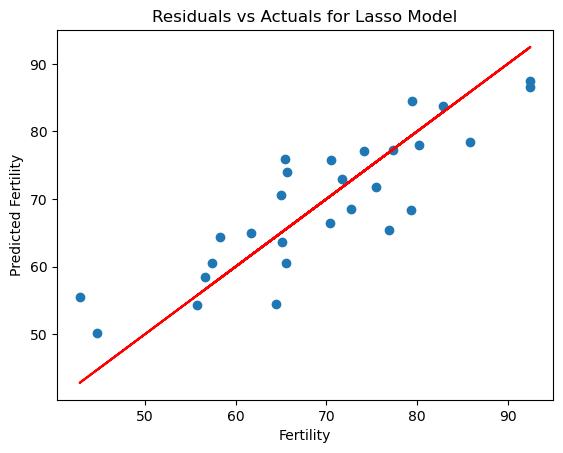

In [83]:
plt.scatter(y, lasso.predict(X), label='lasso')
plt.title('Residuals vs Actuals for Lasso Model')
plt.plot(y,y, ls='-', c='r')
plt.xlabel('Fertility')
plt.ylabel('Predicted Fertility')
plt.show()

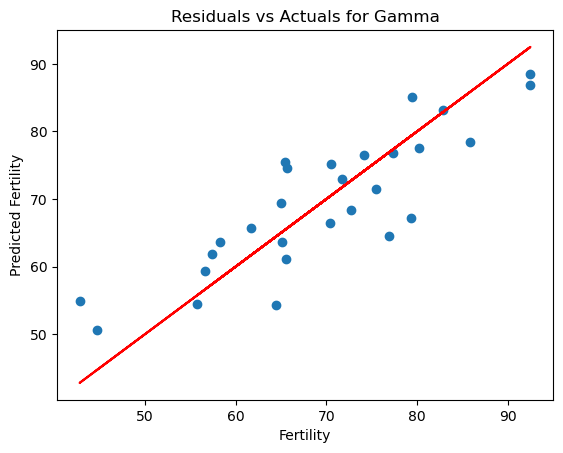

In [85]:
plt.scatter(y, gams.predict(X))
plt.title('Residuals vs Actuals for Gamma')
plt.plot(y,y, ls='-', c='r')
plt.xlabel('Fertility')
plt.ylabel('Predicted Fertility')
plt.show()

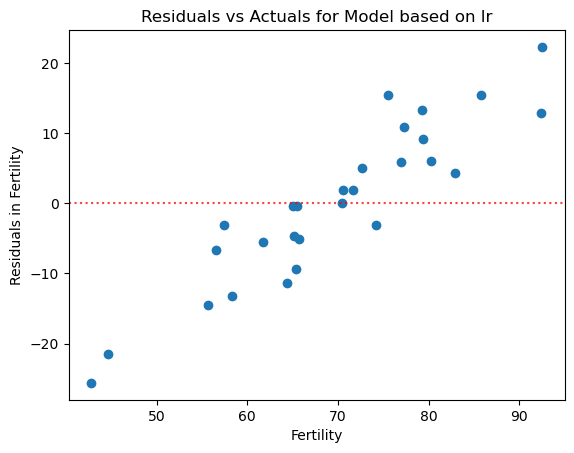

In [71]:
plt.scatter(y, y - lr1.predict(X_train_rfe))
plt.title('Residuals vs Actuals for Model based on lr')
plt.axhline(0, ls=':', c='r', alpha=0.75)
plt.xlabel('Fertility')
plt.ylabel('Residuals in Fertility')
plt.show()

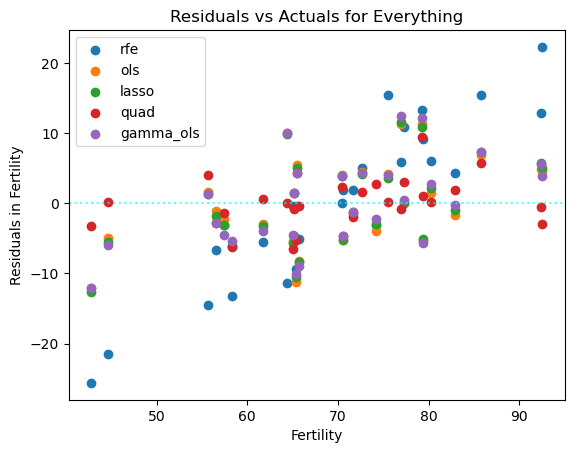

In [88]:
plt.scatter(y, y - lr1.predict(X_train_rfe), label='rfe')
plt.scatter(y, y - lr2.predict(X), label='ols')
plt.scatter(y, y - lasso.predict(X), label='lasso')
plt.scatter(y, y - plyreg.predict(x_train_sq), label='quad')
plt.scatter(y, y - gams.predict(X), label='gamma_ols')
plt.title('Residuals vs Actuals for Everything')
plt.axhline(0, ls=':', c='cyan', alpha=0.67)
plt.xlabel('Fertility')
plt.ylabel('Residuals in Fertility')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Distributions of Predicted Values vs Real Target')

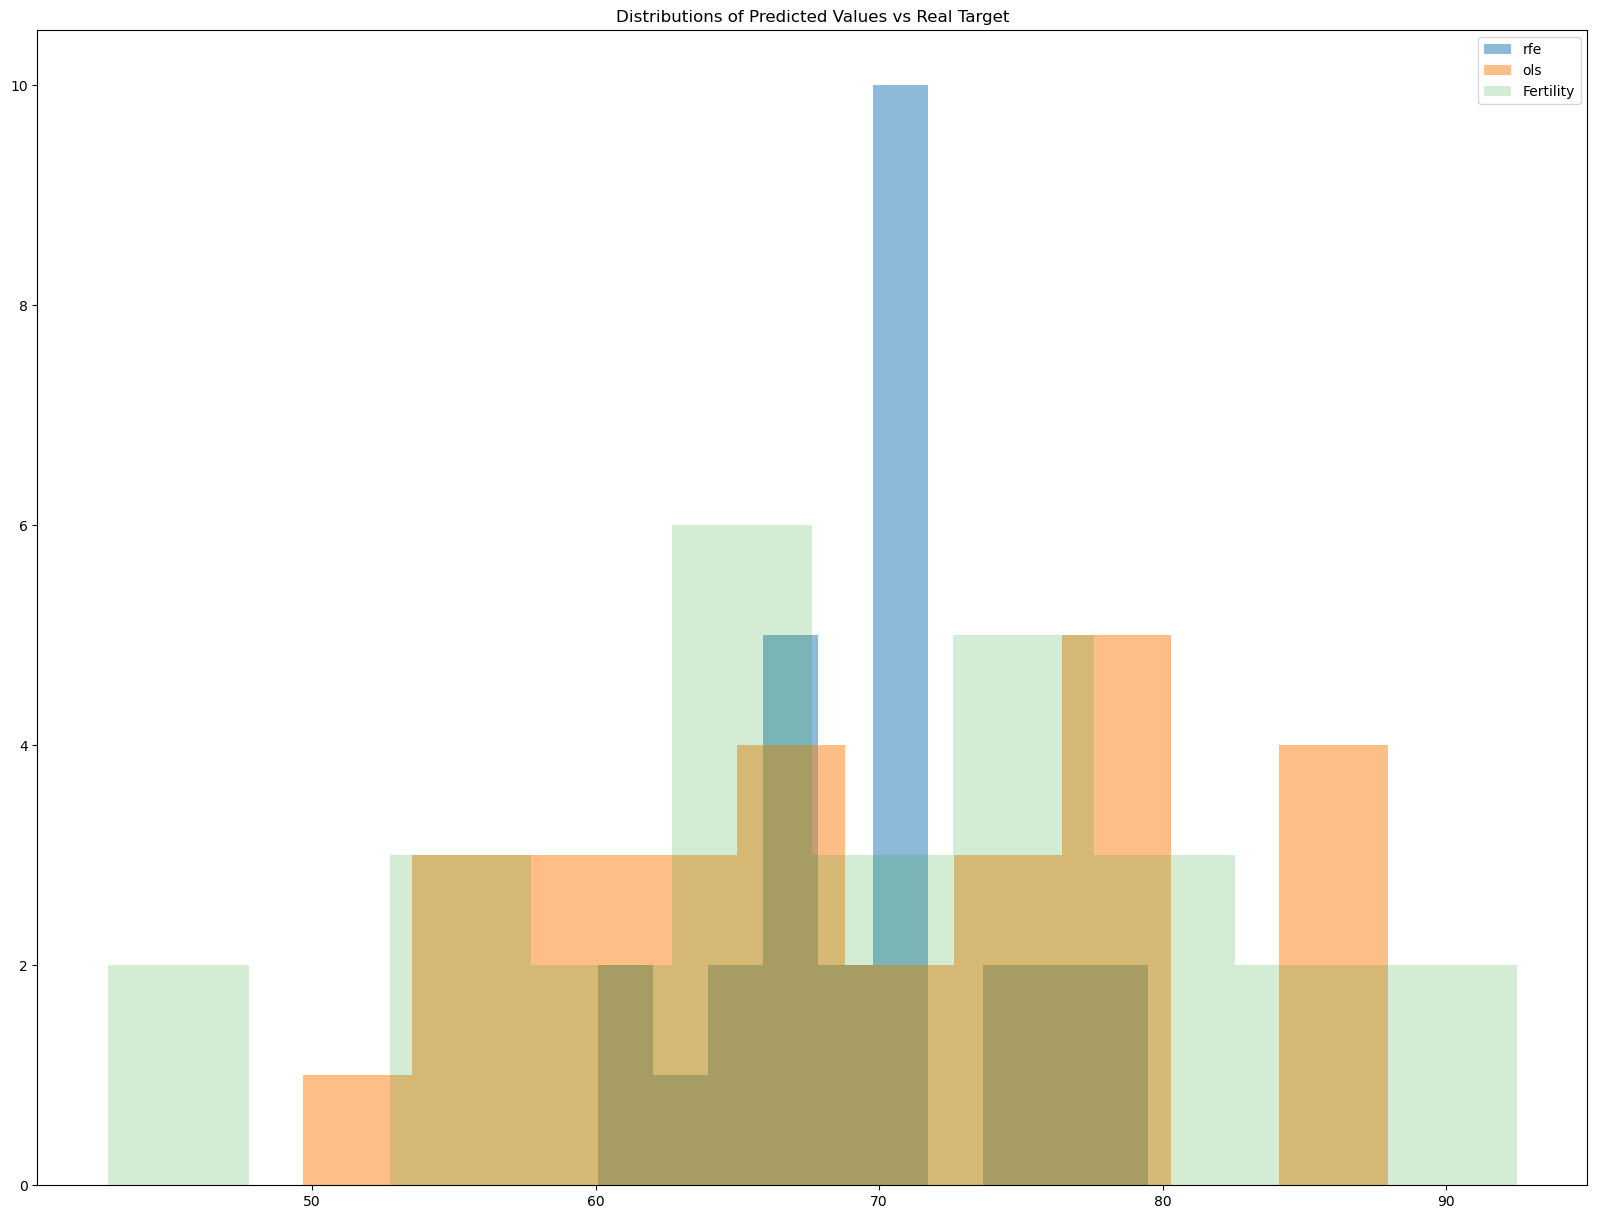

In [75]:
plt.figure(figsize=(20,15))
plt.hist(lr1.predict(X_train_rfe), alpha=0.5, label='rfe')
plt.hist(lr2.predict(X), alpha=0.5, label='ols')
#plt.hist(plyreg.predict(x_train_sq), alpha=0.5, label='quad')
#plt.hist(gams.predict(X), alpha=0.5, label='gamma_ols')
plt.hist(y, alpha=0.2, label='Fertility')
plt.legend()
plt.title('Distributions of Predicted Values vs Real Target')